In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
import math
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper import weight_calc

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()



isData = 0


ntupler_version = 'V1p17/'
mc_path = {}
analyzer_version = 'v1/v162/'
mc_central_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v162/'
mc_private_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


decay = 'dddd'
mass = [  '40']
ctaus  = ['100','1000','10000','100000']
prod = ['ggH', 'VBFH','ZH', 'WH', 'ttH','ggZH']

for ct in ctaus:
    for m in mass:
        for p in prod:
            key = 'MC_'+p + '_'+m+'_'+str(ct)
#             mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
#             fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

            
   
            if p == 'ggH':
                fpath[key] = mc_central_path+p+'_HToSSTodddd_MH-125_MS-'+m+'_ctau-'+str(ct)+'_137000pb_weighted.root'
            else:
                if 'ggH' in p or 'ttH' in p: fpath[key] = mc_private_path+p+'_HToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
                elif p == 'VBFH' or p=='ZH' or p == 'WH': fpath[key] = mc_private_path+p+'ToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
                elif 'ggZH' in p:fpath[key] = mc_private_path+'ZHToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            if not os.path.exists(fpath[key]):print('FILE NOT FOUND',key, fpath[key])

            
            
            
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']

root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']


MC_ggH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all/v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-100_137000pb_weighted.root
MC_VBFH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v162//normalized/VBFHToSS_STodd_ms40_pl100_137000pb_weighted.root
MC_ZH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v162//normalized/ZHToSS_STodd_ms40_pl100_137000pb_weighted.root
MC_WH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v162//normalized/WHToSS_STodd_ms40_pl100_137000pb_weighted.root
MC_ttH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v162//normalized/ttH_HToSS_STodd_ms40_pl100_137000pb_weighted.root
MC_ggZH_40_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v162//normalized/ZHToSS_STod

In [3]:
acceptance = {}
sel_ev = {}
accep_met = {}

sel_ev_cross = {}
sel_ev_csc2 = {}
sel_ev_dt2 = {}
sel_ev_csc1 = {}
sel_ev_dt1 = {}
sel_ev_double = {}
acceptance_dt1 = {}
acceptance_csc1 = {}
acceptance_dt2 = {}
acceptance_csc2 = {}
acceptance_cross = {}
acceptance_2tag = {}
accep_met_dt1 = {}
accep_met_csc1 = {}
accep_met_dt2 = {}
accep_met_csc2 = {}
accep_met_cross = {}
accep_met_2tag = {}
weight = {}
higgsPtWeight = {}


for k, T in tree.items():
    print(k)
#     sel_dtcluster = T.array('dtRechitCluster_match_gLLP')
    sel_dt = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')) < 661, np.abs(T.array('gLLP_decay_vertex_r')) > 380)
    sel_dt = np.logical_and(sel_dt, np.abs(T.array('gLLP_decay_vertex_r')) <738 )
        
        
    sel_csc = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 695.5)
    sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) < 1100 )
    sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) > 661 )

    
    me11 = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 270)
    me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) < 661 )
    me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) > 500 )
    
    sel_csc = np.logical_or(sel_csc, me11) # definition to make sure no overlap
#     sel_csc = T.array('gLLP_csc') # definition for EXO-20-015

#     print(k, np.sum(np.logical_and(sel_csc,sel_dt).sum()))
    sel_ev_cross[k] = np.logical_and(np.sum(sel_csc,axis = 1) == 1, np.sum(sel_dt,axis = 1)==1)
    sel_ev_csc2[k] = np.sum(sel_csc,axis = 1) == 2
    sel_ev_dt2[k] =np.sum(sel_dt,axis = 1) == 2
    sel_ev_csc1[k] = np.sum(sel_csc,axis = 1) >= 1
    sel_ev_dt1[k] =np.sum(sel_dt,axis = 1) >= 1
    sel_ev_double[k] = np.logical_or(np.logical_or(sel_ev_dt2[k], sel_ev_csc2[k]),sel_ev_cross[k])
    
    acceptance_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt1[k]])/np.sum(T.array('weight'))
    acceptance_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]])/np.sum(T.array('weight'))
    acceptance_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt2[k]])/np.sum(T.array('weight'))
    acceptance_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc2[k]])/np.sum(T.array('weight'))
    acceptance_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_cross[k]])/np.sum(T.array('weight'))
    acceptance_2tag[k] = acceptance_dt2[k] + acceptance_csc2[k] + acceptance_cross[k]


    
    sel_ev[k] = np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger'))

    
    accep_met_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt1[k])])/np.sum(T.array('weight'))
    accep_met_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc1[k])])/np.sum(T.array('weight'))
    accep_met_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt2[k])])/np.sum(T.array('weight'))
    accep_met_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc2[k])])/np.sum(T.array('weight'))
    accep_met_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_cross[k])])/np.sum(T.array('weight'))
    
    accep_met_2tag[k] = accep_met_dt2[k] + accep_met_csc2[k] + accep_met_cross[k]
    
    higgsPt = T.array('gHiggsPt')
    higgsEta = T.array('gHiggsEta')
    ggZH_weight=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta)[:,None],axis=1)-1]

    if 'ggH' in k: weight[k] = T.array('weight')*T.array('higgsPtWeight')
    else:weight[k] = T.array('weight')
    if 'ggZH' in k: weight[k] *= ggZH_weight



MC_ggH_40_100
MC_VBFH_40_100
MC_ZH_40_100
MC_WH_40_100
MC_ttH_40_100
MC_ggZH_40_100
MC_ggH_40_1000
MC_VBFH_40_1000
MC_ZH_40_1000
MC_WH_40_1000
MC_ttH_40_1000
MC_ggZH_40_1000
MC_ggH_40_10000
MC_VBFH_40_10000
MC_ZH_40_10000
MC_WH_40_10000
MC_ttH_40_10000
MC_ggZH_40_10000
MC_ggH_40_100000
MC_VBFH_40_100000
MC_ZH_40_100000
MC_WH_40_100000
MC_ttH_40_100000
MC_ggZH_40_100000


# different mass points

In [29]:
plot_ctaus = ['10', '100','200', '500', '700', '1000','2000', '5000', '10000', '50000', '100000','1000000']


In [ ]:




met = True

if met:
    variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    
else: 
    variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_dt2, sel_ev_csc2, sel_ev_cross]
names = ['1 tag DT', '1 tag CSC', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
names = ['1_tagDT', '1_tag_CSC', '2_tag_DT', '2_tag_CSC', '1_DT_1_CSC']
names= ['dt1', 'csc1', 'dt2', 'csc2', 'dt1csc1']


for j, var in enumerate(variables):
    if not j == 2:continue
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    
    rt.gStyle.SetOptFit(1011)
    h = {}
    
    for i, m in enumerate(mass):
#         y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
#         x = np.array([int(a) for a in ctaus])
        x = []
        y = []
        for ct in plot_ctaus:
            if ct in ctaus:
                x.append(int(ct))
                y.append(var['m'+m+'ctau'+ct])
            else:
                
                ctf = int(ct)
                ct_list = 10**int(math.log10(ctf))

                if ctf < int(ctaus[0]): ct_list = [int(ctaus[0])]
                elif ctf > int(ctaus[-1]): ct_list = [int(ctaus[-1])]
                elif ct in ctaus: ct_list = [ctf]
                else:ct_list = [ct_list,ct_list*10]
                sig = 0
                for l, ct0 in enumerate(ct_list):
                    
                    k = 'm'+m+'ctau'+str(ct0)
                    T = tree[k]
#                     print(var.keys())
#                     print(var[k])
                    if var[k] == 0:continue
                    if met: cond = np.logical_and(sel_ev[k], selections[j][k])
                    else: cond = selections[j][k]
                    gLLP_ctau = T.array('gLLP_ctau')[cond]

                    weight_ctau = weight_calc(gLLP_ctau, ctf/10, int(ct0)/10) # convert everything to cm
                    gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[cond]
                    if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                    else:
                        if l == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                        else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                    sig += np.sum((T.array('weight')*T.array('higgsPtWeight'))[cond][weight_cond]*weight_ctau[weight_cond])
                    print(k, np.sum(T.array('weight')))
                x.append(int(ct))
                y.append(sig/np.sum(T.array('weight')))
                

                    
        x = np.array(x)
        y = np.array(y)
        cond = y>0.0
        print(x)
        h[m+str(j)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(j)].SetLineColor(std_color_list[i])
        h[m+str(j)].SetLineWidth(3)
        h[m+str(j)].GetXaxis().SetTitleOffset(1)
        h[m+str(j)].GetYaxis().SetTitleSize(0.05)
        h[m+str(j)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(j)].GetXaxis().SetLimits(0.01,10000.0)
        if met:h[m+str(j)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(j)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(j)], "m_{x} = "+str(m)+" GeV", "L")


    for i,m in enumerate(h.keys()):
        h[m].Draw('CA' if i == 0 else 'Csame')
#         h[m].Draw('LA' if i == 0 else 'Lsame')



    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
    else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+names[j]
    print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
    c.Draw()




In [19]:
plot_ctaus = ['10', '50', '100', '200', '500','700','900', '1000', '2000', '3000','5000', '10000' ,'50000', '100000','1000000', '10000000']
# plot_ctaus = ['10', '100', '1000',  '10000' , '100000','1000000', '10000000']



In [20]:
denominator = 7551796.2

# different detector same mass

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/geometric_accep/accep_mass40.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/geometric_accep/accep_mass40.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/geometric_accep/accep_mass40.pdf has been created


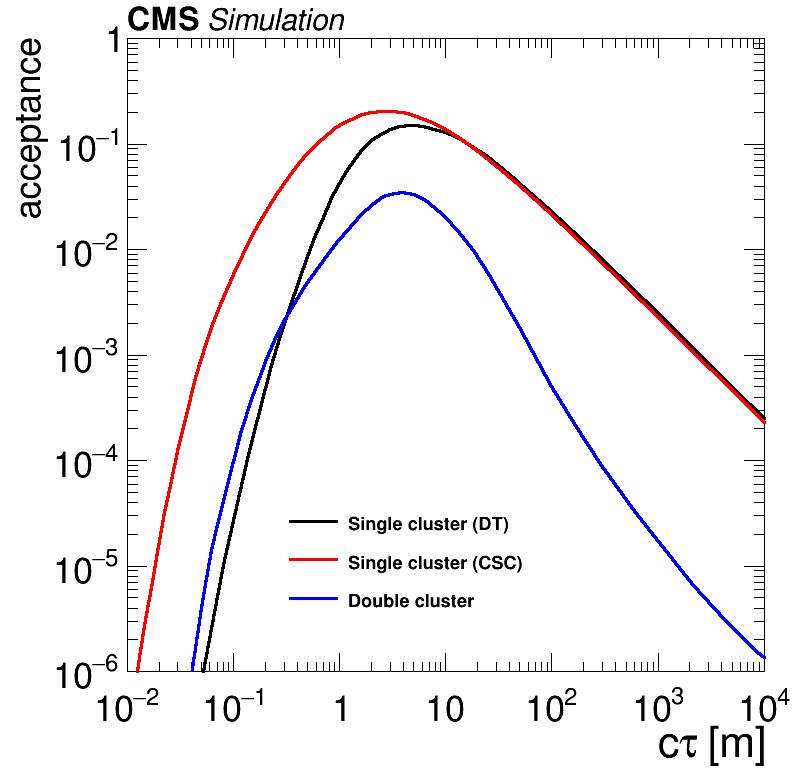

In [25]:
import os


met = 0
# selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_dt2, sel_ev_csc2, sel_ev_cross]

selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_double]


# names = ['Single cluster (DT)', 'Single cluster (CSC)', 'Double cluster (DT + DT)', 'Double cluster (CSC + CSC)', 'Double cluster (DT + CSC)']

names = ['Single cluster (DT)', 'Single cluster (CSC)', 'Double cluster']

if met:
    yaxis = 'acceptance #times met efficiency'
#     variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag]


    
else: 
    yaxis = 'acceptance'
#     variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
    variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag]


# color = [std_color_list[0], std_color_list[1], std_color_list[3], std_color_list[4], std_color_list[5], std_color_list[2]]
color = [std_color_list[0], std_color_list[1], std_color_list[2]]



for j, m in enumerate(mass):
    
#     if not j == 1:continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.35,0.2,0.7,0.35)
    if met: leg = rt.TLegend(0.6,0.75,0.9,0.9)


    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    x = {}
    y = {}
    for i, var in enumerate(variables):
# #         print(i)
        x[i] = []
        y[i] = []
        for ct in plot_ctaus:
            nominator = 0
            for p in prod:
                k = 'MC_'+p+'_'+m+'_'+ct
                
                if ct in ctaus:
                    if met: cond = np.logical_and(sel_ev[k], selections[i][k])
                    else: cond = selections[i][k]
                    nominator += np.sum(weight[k][cond])
                else:
                    ctf = int(ct)
                    ct_list = 10**int(math.log10(ctf))
                    if ctf < int(ctaus[0]): ct_list = [int(ctaus[0])]
                    elif ctf > int(ctaus[-1]): ct_list = [int(ctaus[-1])]
                    elif ct in ctaus: ct_list = [ctf]
                    else:ct_list = [ct_list,ct_list*10]
                    sig = 0
                    for l, ct0 in enumerate(ct_list):

                        k = 'MC_'+p+'_'+m+'_'+str(ct0)
                        T = tree[k]
                        if var[k] == 0:continue
                        if met: cond = np.logical_and(sel_ev[k], selections[i][k])
                        else: cond = selections[i][k]
                        gLLP_ctau = T.array('gLLP_ctau')[cond]

                        weight_ctau = weight_calc(gLLP_ctau, ctf/10, int(ct0)/10) # convert everything to cm
                        gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[cond]
                        if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                        else:
                            if l == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                            else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                        sig += np.sum(weight[k][cond][weight_cond]*weight_ctau[weight_cond])
                    nominator += sig
                    
            x[i].append(int(ct))                
            y[i].append(nominator/denominator)

        x[i] = np.array(x[i])
        y[i] = np.array(y[i])
       
        cond = y[i]*1e19>0.0
        h[i] = create_TGraph(x[i][cond]/1000.0, y[i][cond],  axis_title=['c#tau [m]', yaxis])


        h[i].SetLineColor(std_color_list[i])
        h[i].SetLineWidth(3)
        h[i].GetXaxis().SetTitleOffset(1)
        h[i].GetYaxis().SetTitleSize(0.05)
        h[i].GetYaxis().SetTitleOffset(1.5)
        h[i].GetXaxis().SetLimits(0.01,10000.0)
        if met:h[i].GetYaxis().SetRangeUser(1e-6,0.01)
        else: h[i].GetYaxis().SetRangeUser(1e-6,1)
        leg.AddEntry(h[i], names[i], "L")

    
    
#     for i in [2,3,4]: 
#         h[i].SetLineStyle(2)
#         leg.AddEntry(h[i], names[i], "L")

    
    for i,k in enumerate(h.keys()):
        h[k].SetLineColor(color[i])
#         if i < 5 and i >1:h[k].SetLineStyle(9)
        h[k].Draw('CA' if i == 0 else 'Csame')

#         h[k].Draw('LA' if i == 0 else 'Lsame')


    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
    CMS_lumi.cmsText     = "CMS"
    CMS_lumi.relPosX = 0.12
    CMS_lumi.relPosY = 0.0
    CMS_lumi.writeExtraText = 1
    CMS_lumi.extraText   = "Simulation"
    CMS_lumi.CMS_lumi(c, 0, 0)


    output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/geometric_accep/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+'accep_mass'+m
    if met: name += '_metcut'
    

    c.SaveAs(name+'.png')
    c.SaveAs(name+'.C')
    c.SaveAs(name+'.pdf')

    c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


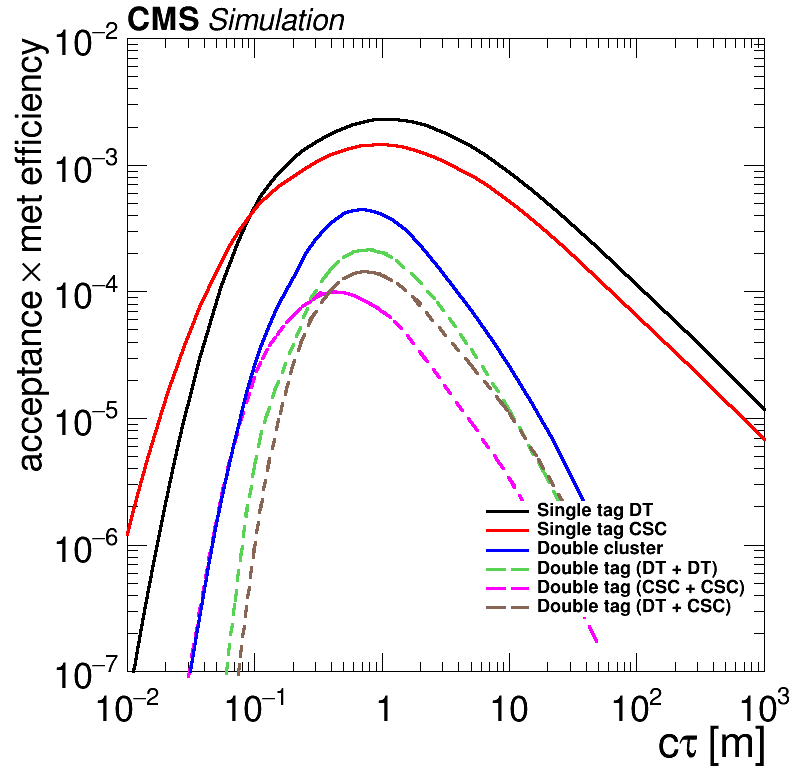

In [74]:
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
# leg = rt.TLegend(0.6,0.2,0.9,0.35)
# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)
   
color = [std_color_list[0], std_color_list[1], std_color_list[3], std_color_list[4], std_color_list[5], std_color_list[2]]
        
for i,k in enumerate(h.keys()):
    h[k].GetYaxis().SetTitle('acceptance #times met efficiency')
    h[k].GetXaxis().SetTitleOffset(1)
    h[k].GetYaxis().SetTitleSize(0.05)
    h[k].GetYaxis().SetTitleOffset(1.5)
    h[k].GetXaxis().SetLimits(0.01,1000.0)
#     if met:h[k].GetYaxis().SetRangeUser(1e-8,0.01)
    h[k].SetLineColor(color[i])
    if i < 5 and i >1:h[k].SetLineStyle(9)
    h[k].GetYaxis().SetRangeUser(1e-7,0.01)
    h[k].Draw('CA' if i == 0 else 'Csame')

leg.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)

CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation"
if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 0, iPos)
c.Draw()





[   100   1000  10000 100000] [0.00051871 0.00245022 0.0008714  0.00010995]
[   100   1000  10000 100000] [6.1465416e-04 1.6119396e-03 5.4284831e-04 6.6587017e-05]
[   100   1000  10000 100000] [2.8408962e-05 4.3636872e-04 2.3566145e-05 4.5320724e-07]
[   100   1000  10000 100000] [2.7982485e-06 2.0721632e-04 1.0815684e-05 2.7317640e-07]
[   100   1000  10000 100000] [2.4624309e-05 8.4504209e-05 3.6569836e-06 1.8003082e-07]
[   100   1000  10000 100000] [9.8640521e-07 1.4464819e-04 9.0934773e-06 0.0000000e+00]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


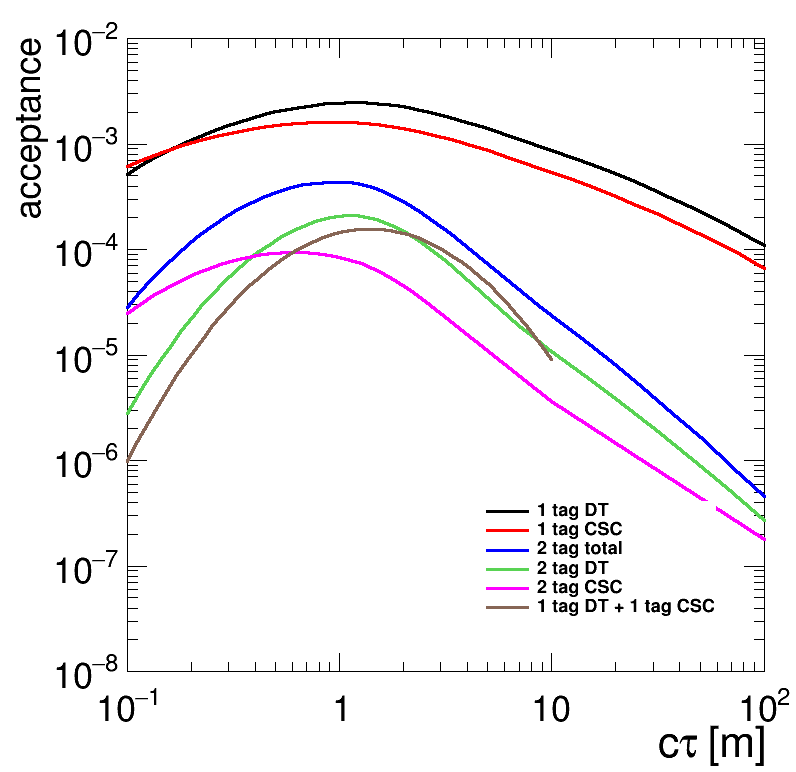

In [6]:
import os


met = 1


names = ['1 tag DT', '1 tag CSC', '2 tag total', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag, accep_met_dt2, accep_met_csc2, accep_met_cross]
else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, var in enumerate(variables):


        y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
        x = np.array([int(a) for a in ctaus])
        
        cond = y>0.0
        print(x, y)
        h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(i)].SetLineColor(std_color_list[i])
        h[m+str(i)].SetLineWidth(3)
        h[m+str(i)].GetXaxis().SetTitleOffset(1)
        h[m+str(i)].GetYaxis().SetTitleSize(0.05)
        h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(i)].GetXaxis().SetLimits(0.1,100.0)
        if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(i)], names[i], "L")


    for i,k in enumerate(h.keys()):
        h[k].Draw('CA' if i == 0 else 'Csame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+'mass'+m

#     if total:
#         c.SaveAs(name+'_all.png')
#         c.SaveAs(name+'_all.C')
#         c.SaveAs(name+'_all.pdf')
#     else:
#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

    c.Draw()






# hepdata plot for EXO-20-015

[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    

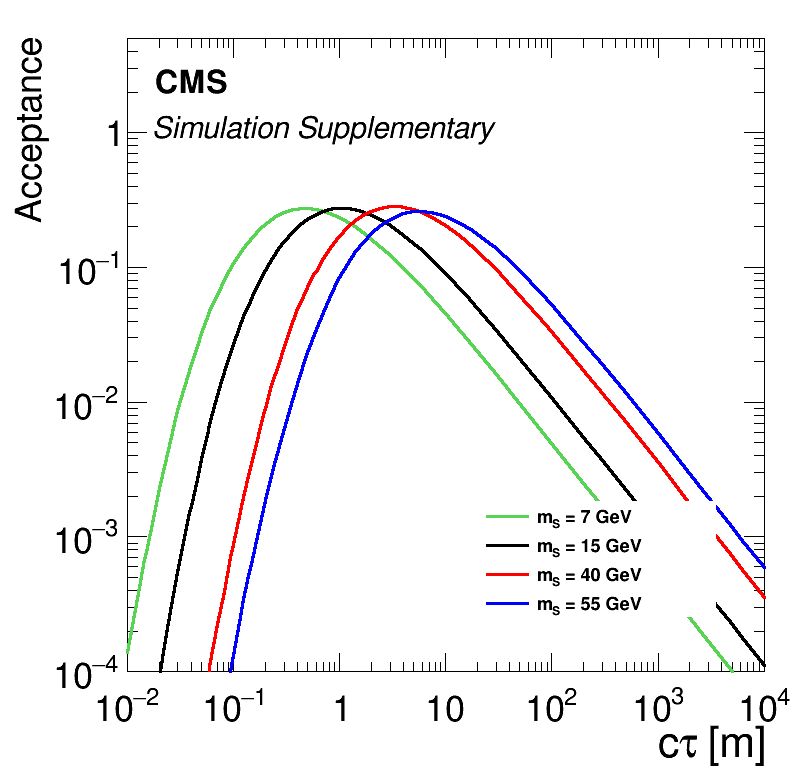

In [4]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
import math
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from helper import  weight_calc

importlib.reload(sys.modules['CMS_lumi'])


OLD_CTAU= [100,1000,10000,100000]



leg = rt.TLegend(0.6,0.2,0.9,0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}

ctaus = ['5','10','15','20','30','40', '50','60', '100', '125','150','200','300','500','600','700','800','900','1000', '2000','3000','4000', '5000', '6000','7000','8000','10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000', '2000000', '3000000', '5000000', '6000000', '10000000'] #mm
acceptance = {}

for i, m in enumerate(mass):
    acceptance[m] = []
    #ctau reweighting
    for ct in ctaus:
        accep_temp = 0
        ctf = int(ct)
        ct_list = 10**int(math.log10(ctf))
        if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
        elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
        elif ct_list == int(ct): ct_list = [int(ct)]
        else:ct_list = [ct_list,ct_list*10]
   
        
        for j, ct0 in enumerate(ct_list):
            k = 'm'+str(m)+'ctau'+str(ct0)
            T = tree[k]
            if np.count_nonzero(sel_ev_csc1[k])==0:continue
            gLLP_ctau = T.array('gLLP_ctau')[sel_ev_csc1[k]]
            weight_ctau = weight_calc(gLLP_ctau, int(ct)/10, int(ct0)/10) # convert everything to cm
            gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev_csc1[k]]
            if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
            else:
                if j == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
            weight = (T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]]
            w = (weight*weight_ctau)[weight_cond]
            accep_temp += np.sum(w)
        acceptance[m].append(accep_temp/6664892.0)
#         print(ct, m, acceptance[m][-1])
    
    #######################
    
#     y = np.array([acceptance_csc1['m'+m+'ctau100'], acceptance_csc1['m'+m+'ctau1000'], acceptance_csc1['m'+m+'ctau10000'], acceptance_csc1['m'+m+'ctau100000']])
    x = np.array([int(a) for a in ctaus])
    y = np.array(acceptance[m])
    cond = y>0.0
    print(x)
    h[m] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'Acceptance'])


    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])

    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)
    h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,5)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    
    ###### save to text file for hepdata ######
    outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/'
    if not os.path.isdir(outputDir):os.makedirs(outputDir)
    outputFileName = outputDir + 'acceptance_m'+str(m)
    outputFileName += '.txt'
    np.savetxt(outputFileName, np.column_stack((x[cond]/1000.0, y[cond])), delimiter="\t")


for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')

CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.1
CMS_lumi.relPosY = 0.05        
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 11)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/csc/acceptance/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.pdf has been created


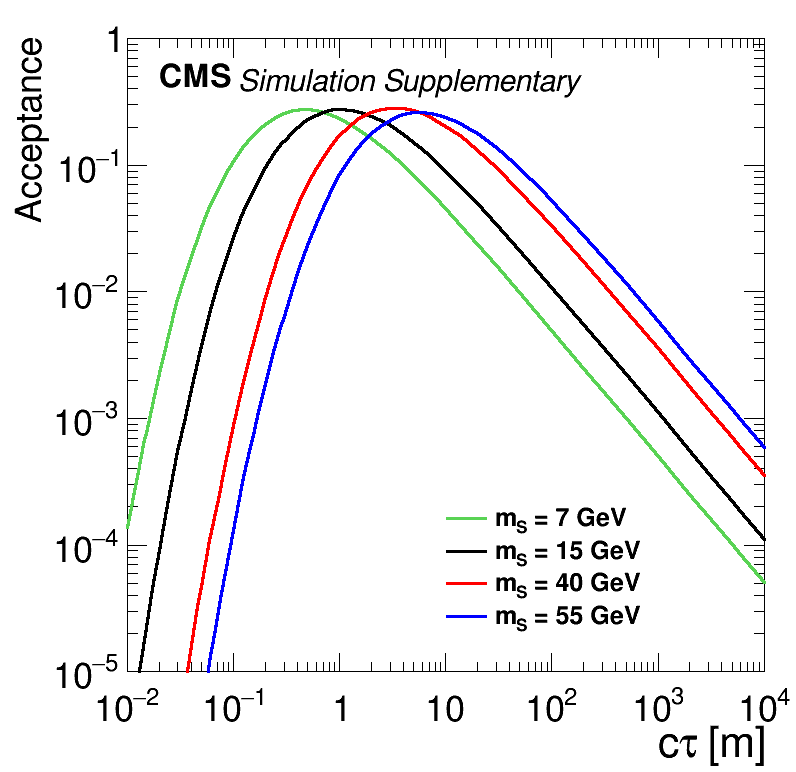

In [14]:
importlib.reload(sys.modules['CMS_lumi'])


leg = rt.TLegend(0.55,0.18,0.84,0.35)
# leg = rt.TLegend(0.7,0.75,0.84,0.9)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
for i,m in enumerate(h.keys()):
    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,1)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')


CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.05
CMS_lumi.relPosY = 0.041      
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 10)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


c.SaveAs(output_dir+'csc_acceptance.png')
c.SaveAs(output_dir+'csc_acceptance.C')
c.SaveAs(output_dir+'csc_acceptance.pdf')
c.Draw()



